 ## Import Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from pathlib import Path

data_path = Path.cwd().parent / "data"

In [2]:
print(f"Python version -> {sys.version}")  # 3.12.3
print(f"torch version -> {torch.__version__}")  # 2.8.0+cu128

Python version -> 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
torch version -> 2.8.0+cu128


 ## PL Data From CSV

In [3]:
data = pd.read_csv(data_path / "PL_data.csv", sep=";")

x = data[
    [
        "Headcount",
        "Mean",
        "Median",
        "Gini",
        "Population.Density",
        "Urban.Pop",
        "Age.Dependency",
    ]
]
y = data[["Poverty.Line.Month"]]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=123
)

 ## Data Normalization

In [4]:
mean = x_train.mean()
std = x_train.std()

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

mean_data = y_train.mean()
std_data = y_test.std()

y_train = (y_train - y_train.mean()) / y_train.std()
y_test = (y_test - y_test.mean()) / y_test.std()


# Convert to numpy then tensors
x_train, y_train = np.array(x_train, dtype=np.float32), np.array(
    y_train, dtype=np.float32
)
x_test, y_test = np.array(x_test, dtype=np.float32), np.array(y_test, dtype=np.float32)

x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train)
x_test_tensor = torch.tensor(x_test)
y_test_tensor = torch.tensor(y_test)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("x_train shape:", x_train.shape)
print("x_test shape :", x_test.shape)

x_train shape: (385, 7)
x_test shape : (97, 7)


 ## Model Definition

A neural network in pytorch must inherit from `torch.nn.module` and implement a `forward` method.

In [5]:
class PovertyLineModel(nn.Module):
    def __init__(self, input_dim):
        super(PovertyLineModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)  # same as Keras input layer
        self.fc2 = nn.Linear(input_dim, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        # x = self.relu(self.fc5(x))
        return self.fc5(x)


input_dim = x_train.shape[1]
model = PovertyLineModel(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

PovertyLineModel(
  (fc1): Linear(in_features=7, out_features=7, bias=True)
  (fc2): Linear(in_features=7, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)


Here is an alternative way using `torch.Sequential` and `LazyLinear` layers (lazy because we don't specify the number of in features) 

In [6]:
class PovertyLineModel(nn.Module):
    def __init__(self, first_layer_dim):
        super(PovertyLineModel, self).__init__()
        self.activation = nn.ReLU()
        self.layers = nn.Sequential(
            nn.LazyLinear(first_layer_dim),
            self.activation,
            nn.LazyLinear(32),
            self.activation,
            nn.LazyLinear(64),
            self.activation,
            nn.LazyLinear(1),
        )

    def forward(self, x):
        return self.layers(x)


input_dim = x_train.shape[1]
model = PovertyLineModel(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

PovertyLineModel(
  (activation): ReLU()
  (layers): Sequential(
    (0): LazyLinear(in_features=0, out_features=7, bias=True)
    (1): ReLU()
    (2): LazyLinear(in_features=0, out_features=32, bias=True)
    (3): ReLU()
    (4): LazyLinear(in_features=0, out_features=64, bias=True)
    (5): ReLU()
    (6): LazyLinear(in_features=0, out_features=1, bias=True)
  )
)


 ## Compile (Loss, Optimizer)

In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

 ## Train the Model

In [8]:
epochs = 400

train_losses, val_losses, train_mae, val_mae = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_loss, running_mae = 0.0, 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_mae += torch.mean(torch.abs(outputs - targets)).item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss, val_mae_epoch = 0.0, 0.0
    with torch.no_grad():
        for inputs, target in test_loader:
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, target).item()
            val_mae_epoch += torch.mean(torch.abs(outputs - target)).item()

    val_losses.append(val_loss / len(test_loader))
    train_mae.append(running_mae / len(train_loader))
    val_mae.append(val_mae_epoch / len(test_loader))

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(
            f"Epoch [{epoch+1}/{epochs}] "
            f"Loss: {train_losses[-1]:.4f}, Val_Loss: {val_losses[-1]:.4f}, "
            f"MAE: {train_mae[-1]:.4f}, Val_MAE: {val_mae[-1]:.4f}"
        )

Epoch [1/400] Loss: 0.9613, Val_Loss: 0.9427, MAE: 0.7744, Val_MAE: 0.7340
Epoch [10/400] Loss: 0.8746, Val_Loss: 0.8738, MAE: 0.7275, Val_MAE: 0.7010
Epoch [20/400] Loss: 0.7897, Val_Loss: 0.7800, MAE: 0.6805, Val_MAE: 0.6498
Epoch [30/400] Loss: 0.6158, Val_Loss: 0.6664, MAE: 0.5565, Val_MAE: 0.5912
Epoch [40/400] Loss: 0.5005, Val_Loss: 0.5506, MAE: 0.4642, Val_MAE: 0.5244
Epoch [50/400] Loss: 0.4089, Val_Loss: 0.4443, MAE: 0.4065, Val_MAE: 0.4586
Epoch [60/400] Loss: 0.3143, Val_Loss: 0.3305, MAE: 0.3544, Val_MAE: 0.4089
Epoch [70/400] Loss: 0.2723, Val_Loss: 0.2572, MAE: 0.3512, Val_MAE: 0.3695
Epoch [80/400] Loss: 0.2080, Val_Loss: 0.1938, MAE: 0.3127, Val_MAE: 0.3380
Epoch [90/400] Loss: 0.2679, Val_Loss: 0.1419, MAE: 0.3722, Val_MAE: 0.2986
Epoch [100/400] Loss: 0.1288, Val_Loss: 0.1181, MAE: 0.2480, Val_MAE: 0.2790
Epoch [110/400] Loss: 0.1714, Val_Loss: 0.1052, MAE: 0.3084, Val_MAE: 0.2669
Epoch [120/400] Loss: 0.1119, Val_Loss: 0.1007, MAE: 0.2338, Val_MAE: 0.2569
Epoch [130

 ## Evaluate Model

Text(0.5, 1.0, 'MAE')

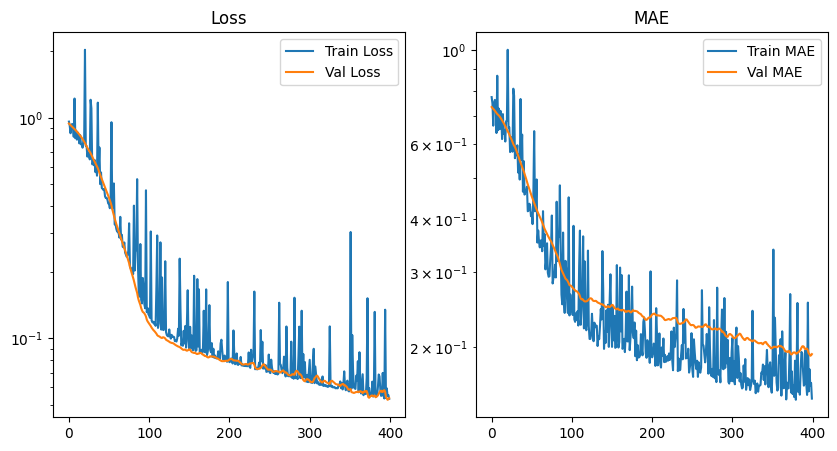

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss")
plt.yscale("log")


plt.subplot(1, 2, 2)
plt.plot(train_mae, label="Train MAE")
plt.plot(val_mae, label="Val MAE")
plt.legend()
plt.yscale("log")
plt.title("MAE")

Text(0.5, 1.0, 'MAE')

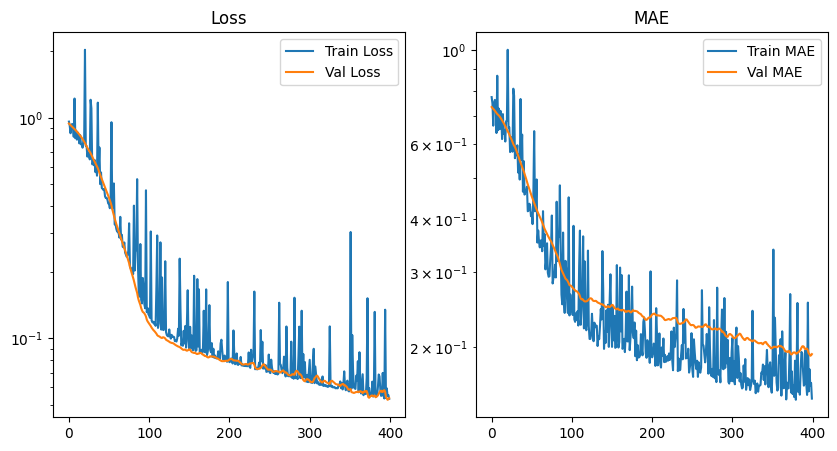

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss")
plt.yscale("log")


plt.subplot(1, 2, 2)
plt.plot(train_mae, label="Train MAE")
plt.plot(val_mae, label="Val MAE")
plt.legend()
plt.yscale("log")
plt.title("MAE")

 ## Prediction

In [14]:
my_data = [-1.07, 1.02, 0.98, -0.41, -0.48, 0.69, -0.64]
real_PL = 337.29

my_data_tensor = torch.tensor(my_data).reshape(1, -1)

model.eval()
with torch.no_grad():
    prediction = (
        model(my_data_tensor).cpu().item() * std_data.values + mean_data.values
    ).item()

print(f"Prediction : {prediction:.2f} K$")
print(f"Reality    : {real_PL:.2f} K$")

Prediction : 347.64 K$
Reality    : 337.29 K$


# Further explorations

What about the distribution of the target ?

(array([ 2.,  0., 11., 25., 47., 51., 41., 28., 41., 45., 42., 40., 18.,
        15., 13.,  9.,  9., 16., 23.,  6.]),
 array([3.08601319, 3.28148494, 3.4769567 , 3.67242845, 3.8679002 ,
        4.06337196, 4.25884371, 4.45431546, 4.64978721, 4.84525897,
        5.04073072, 5.23620247, 5.43167423, 5.62714598, 5.82261773,
        6.01808948, 6.21356124, 6.40903299, 6.60450474, 6.7999765 ,
        6.99544825]),
 <BarContainer object of 20 artists>)

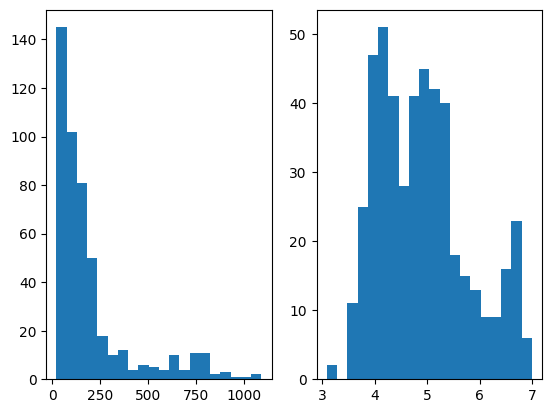

In [22]:
plt.subplot(1, 2, 1)
plt.hist(y, bins=20)
plt.subplot(1, 2, 2)
plt.hist(np.log(y), bins=20)

We can try to transform first the output data to have something more "normally" distributed